![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [90]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


## EDA

In [91]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


In [92]:
cc_apps.shape

(690, 14)

In [93]:
def analyze_columns(df):
    """
    This function checks for missing values, analyzes categorical columns 
    with fewer than 20 unique values, and prints relevant information 
    for each column in the DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.
    """
    for col in df.columns:
        # Check if the column contains missing values
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"Value counts for {col} (missing values present: {missing_count}):")
        else:
            print(f"No missing values for {col}")

        # Check if the column is of object type (categorical)
        if df[col].dtype == 'object':
            # Check if the number of unique values is less than 20
            if df[col].nunique() < 20:
                print(f"Value counts for {col} (categorical with < 20 unique values):")
                print(df[col].value_counts(dropna=False))  # Include NaN in the value counts
                print("-" * 50)
            else:
                print(f"{col} has more than 20 unique values.")
                print(f"Number of unique values in {col}: {df[col].nunique()}")
                print("-" * 50)
        else:
            print(f"{col} is not a categorical column, skipping.")
            print("-" * 50)

In [94]:
analyze_columns(cc_apps)

No missing values for 0
Value counts for 0 (categorical with < 20 unique values):
b    468
a    210
?     12
Name: 0, dtype: int64
--------------------------------------------------
No missing values for 1
1 has more than 20 unique values.
Number of unique values in 1: 350
--------------------------------------------------
No missing values for 2
2 is not a categorical column, skipping.
--------------------------------------------------
No missing values for 3
Value counts for 3 (categorical with < 20 unique values):
u    519
y    163
?      6
l      2
Name: 3, dtype: int64
--------------------------------------------------
No missing values for 4
Value counts for 4 (categorical with < 20 unique values):
g     519
p     163
?       6
gg      2
Name: 4, dtype: int64
--------------------------------------------------
No missing values for 5
Value counts for 5 (categorical with < 20 unique values):
c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x

In [95]:
# Iterate through each column in the dataset
for col in cc_apps.columns:
    # Check if the column contains "?" values
    if cc_apps[col].dtype == 'object' and '?' in cc_apps[col].values:
        # Replace "?" with the mode of the column
        mode_value = cc_apps[col].mode()[0]  # Get the mode (most frequent value)
        cc_apps[col] = cc_apps[col].replace('?', mode_value)

Recheck the values

In [96]:
analyze_columns(cc_apps)

No missing values for 0
Value counts for 0 (categorical with < 20 unique values):
b    480
a    210
Name: 0, dtype: int64
--------------------------------------------------
No missing values for 1
1 has more than 20 unique values.
Number of unique values in 1: 350
--------------------------------------------------
No missing values for 2
2 is not a categorical column, skipping.
--------------------------------------------------
No missing values for 3
Value counts for 3 (categorical with < 20 unique values):
u    525
y    163
l      2
Name: 3, dtype: int64
--------------------------------------------------
No missing values for 4
Value counts for 4 (categorical with < 20 unique values):
g     525
p     163
gg      2
Name: 4, dtype: int64
--------------------------------------------------
No missing values for 5
Value counts for 5 (categorical with < 20 unique values):
c     146
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25

In [97]:
mapping_dicts = {
    't' : 1, 'f' : 0,
    '+' : 1, '-' : 0,
    'a' : 1, 'b' : 0
}

# List of columns where the mappings should be applied
columns_to_map = [0, 8, 9, 13]

# Apply the mapping to each specified column in a loop
for col in columns_to_map:
    cc_apps[col] = cc_apps[col].map(mapping_dicts)

# Display the updated DataFrame to verify the changes
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,30.83,0.000,u,g,w,v,1.25,1,1,1,g,0,1
1,1,58.67,4.460,u,g,q,h,3.04,1,1,6,g,560,1
2,1,24.50,0.500,u,g,q,h,1.50,1,0,0,g,824,1
3,0,27.83,1.540,u,g,w,v,3.75,1,1,5,g,3,1
4,0,20.17,5.625,u,g,w,v,1.71,1,0,0,s,0,1


In [98]:
# Remove rows with '?' in column '1'
cc_apps = cc_apps[cc_apps[1] != '?']

# Now convert to float32
cc_apps[1] = cc_apps[1].astype('float32')

In [99]:
matching_columns = []

for col in cc_apps.columns:
    if cc_apps[col].dtype == 'object' and cc_apps[col].nunique() > 2:
        matching_columns.append(col)
        
matching_columns


[3, 4, 5, 6, 11]

In [100]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    int64  
 1   1       678 non-null    float32
 2   2       678 non-null    float64
 3   3       678 non-null    object 
 4   4       678 non-null    object 
 5   5       678 non-null    object 
 6   6       678 non-null    object 
 7   7       678 non-null    float64
 8   8       678 non-null    int64  
 9   9       678 non-null    int64  
 10  10      678 non-null    int64  
 11  11      678 non-null    object 
 12  12      678 non-null    int64  
 13  13      678 non-null    int64  
dtypes: float32(1), float64(2), int64(6), object(5)
memory usage: 76.8+ KB


In [101]:
cc_apps = pd.get_dummies(cc_apps, prefix='ohe', columns=matching_columns, drop_first=True)

print(cc_apps.head())

   0          1      2     7  8  9  ...  ohe_n  ohe_o  ohe_v  ohe_z  ohe_p  ohe_s
0  0  30.830000  0.000  1.25  1  1  ...      0      0      1      0      0      0
1  1  58.669998  4.460  3.04  1  1  ...      0      0      0      0      0      0
2  1  24.500000  0.500  1.50  1  0  ...      0      0      0      0      0      0
3  0  27.830000  1.540  3.75  1  1  ...      0      0      1      0      0      0
4  0  20.170000  5.625  1.71  1  0  ...      0      0      1      0      0      1

[5 rows x 36 columns]


In [102]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 689
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    int64  
 1   1       678 non-null    float32
 2   2       678 non-null    float64
 3   7       678 non-null    float64
 4   8       678 non-null    int64  
 5   9       678 non-null    int64  
 6   10      678 non-null    int64  
 7   12      678 non-null    int64  
 8   13      678 non-null    int64  
 9   ohe_u   678 non-null    uint8  
 10  ohe_y   678 non-null    uint8  
 11  ohe_gg  678 non-null    uint8  
 12  ohe_p   678 non-null    uint8  
 13  ohe_c   678 non-null    uint8  
 14  ohe_cc  678 non-null    uint8  
 15  ohe_d   678 non-null    uint8  
 16  ohe_e   678 non-null    uint8  
 17  ohe_ff  678 non-null    uint8  
 18  ohe_i   678 non-null    uint8  
 19  ohe_j   678 non-null    uint8  
 20  ohe_k   678 non-null    uint8  
 21  ohe_m   678 non-null    uint8  
 22  oh

In [103]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, \
    recall_score, classification_report
from sklearn.pipeline import Pipeline

# Convert all column names to strings
X = cc_apps.drop(columns=13)
X.columns = X.columns.astype(str)
y = cc_apps[13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [104]:

steps = [
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
]

# Create the pipeline
pipeline = Pipeline(steps=steps)

# Define the hyperparameter space for GridSearchCV
param_grid = {
    'logistic_regression__C': [0.1, 1, 10],  
    'logistic_regression__penalty': ['l1', 'l2'],  
    'logistic_regression__solver': ['liblinear']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('logistic_regression',
                                        LogisticRegression())]),
             param_grid={'logistic_regression__C': [0.1, 1, 10],
                         'logistic_regression__penalty': ['l1', 'l2'],
                         'logistic_regression__solver': ['liblinear']},
             scoring='accuracy')

In [105]:
# Get the best parameters
print(f"Best parameters found: {grid_search.best_params_}")


# Evaluate the model on the test set using the best parameters
best_model = grid_search.best_estimator_
best_score = best_model.score(X_test, y_test)

# Display the test score
print(f"Test accuracy with best model: {test_score}")

Best parameters found: {'logistic_regression__C': 1, 'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'liblinear'}
Test accuracy with best model: 0.875


In [106]:
best_model

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=1, penalty='l1', solver='liblinear'))])

In [107]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Get the model accuracy
score = best_model.score(X_test, y_test)

# Display the accuracy score
print(f"Model accuracy: {score}")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89        75
           1       0.87      0.85      0.86        61

    accuracy                           0.88       136
   macro avg       0.87      0.87      0.87       136
weighted avg       0.87      0.88      0.87       136



In [108]:
import matplotlib.pyplot as plt

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_fontsize='medium'):  # Add a parameter for text font size
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=text_fontsize)  # Set the font size here

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.89333333 0.10666667]
 [0.14754098 0.85245902]]


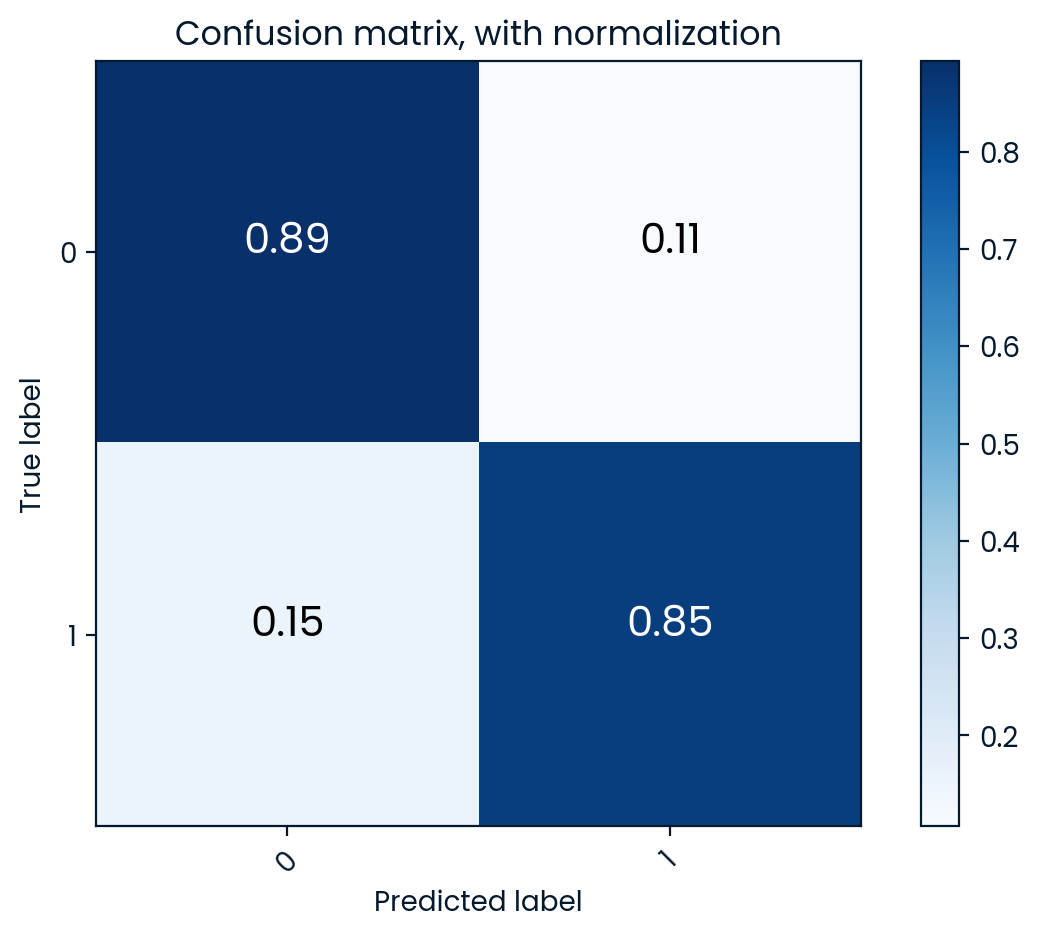

In [110]:
cnf = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf, classes=['0','1'], normalize = True,
                      title='Confusion matrix, with normalization',text_fontsize=15)